In [1]:
from model import NSFrozenLake
import numpy as np
from amalearn.agent import AgentBase
import matplotlib.pyplot as plt
import math
from collections import defaultdict


In [2]:
class NSFrozenLake_new(NSFrozenLake):
    def __init__(self, studentNum: int = 256, nonStationary=False):
        super().__init__(studentNum, nonStationary)
        self.actions = {0:(0,-1), 1:(1,0), 2:(0,1), 3:(-1,0)}
        self.states = np.array([[(i,j) for j in range (0,4)] for i in range(0,4)])

In [46]:
class onPolicyMonteCarlo():
    def __init__(self, env, d_factor, epsilon, epsilon_decay):
        self.env = env
        self.gamma = d_factor
        self.q_table = np.zeros((4,4,4))
        self.rewards_sum = defaultdict(float)
        self.rewards_count = defaultdict(float)
        self.mc_episode_scores = []
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(np.array(list(self.env.actions.keys())))
        else:
            return np.argmax(self.q_table[:,state[0], state[1]])

    def learn(self, episodes, max_steps):
        for episode in range(episodes):
            episode_reward = 0
            state = self.env.reset()
            self.episode_info = []
            done = False
            steps = 0
            while(True):
                action = self.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                self.episode_info.append([state, action, reward])
                state = next_state
                if done or steps == max_steps :
                    break
            
            if self.epsilon_decay:
                self.epsilon = max(self.epsilon * 0.99, 0.1)

            self.update_q_table()
            self.mc_episode_scores.append(episode_reward)
            if episode%100==0:
                print("Episode: ", episode, " Episode reward: ", episode_reward)

    
    def update_q_table(self):
        # print(self.episode_info)
        episode_unique_pairs = set([(x[0], x[1]) for x in self.episode_info])
        # print(episode_unique_pairs)
        for state, action in episode_unique_pairs:
            # print(state, action)
            first_visit_index = min([idx for idx, thing in enumerate(self.episode_info) if thing[0] == state and thing[1] == action])
            # print(first_visit_index)
            rewards_list = [(self.gamma**i) * x[2] for i, x in enumerate(self.episode_info[first_visit_index:])]
            g = sum(rewards_list)
            self.rewards_sum[(state, action)] += g
            self.rewards_count[(state, action)] += 1
            self.q_table[action, state[0], state[1]] = self.rewards_sum[(state, action)]/self.rewards_count[(state, action)]
    
    def reset(self):
        self.__init__(self.env, self.gamma, self.epsilon, self.epsilon_decay)


In [4]:
def mean_rewards_over_window(values, window=50):
    weight = np.repeat(1.0, window)/window
    means_list = np.convolve(values,weight,'valid')
    return means_list

In [54]:
STUDENT_NUMBER = 810196662
EPISODES = 4000
MAX_STEPS = 30
DISCOUNT_FACTOR = 0.9
LEARNING_SESSIONS = 20

episode_rewards_list_1 = []
episode_rewards_list_2 = []
episode_rewards_list_3 = []

env = NSFrozenLake_new(STUDENT_NUMBER)


for i in range(LEARNING_SESSIONS):

    agent_1 = onPolicyMonteCarlo(env, DISCOUNT_FACTOR, 1, True)
    agent_2 = onPolicyMonteCarlo(env, DISCOUNT_FACTOR, 0.1, False)
    agent_3 = onPolicyMonteCarlo(env, DISCOUNT_FACTOR, 0.05, False)

    print("Learning Session: ", i)
    
    print("Agent 1 started training!")
    agent_1.learn(EPISODES, MAX_STEPS)
    episode_rewards_list_1.append(agent_1.mc_episode_scores)
    print("Agent 2 started training!")
    agent_2.learn(EPISODES, MAX_STEPS)
    episode_rewards_list_2.append(agent_2.mc_episode_scores)
    print("Agent 3 started training!")
    agent_3.learn(EPISODES, MAX_STEPS)
    episode_rewards_list_3.append(agent_3.mc_episode_scores)
    

mean_rewards_1 = mean_rewards_over_window(np.average(episode_rewards_list_1, axis=0), window=50)
mean_rewards_2 = mean_rewards_over_window(np.average(episode_rewards_list_2, axis=0), window=50)
mean_rewards_3 = mean_rewards_over_window(np.average(episode_rewards_list_3, axis=0), window=50)


Learning Session:  0
Agent 1 started training!
Episode:  0  Episode reward:  -14
Episode:  100  Episode reward:  42
Episode:  200  Episode reward:  40
Episode:  300  Episode reward:  -16
Episode:  400  Episode reward:  44
Episode:  500  Episode reward:  43
Episode:  600  Episode reward:  -14
Episode:  700  Episode reward:  44
Episode:  800  Episode reward:  44
Episode:  900  Episode reward:  44
Episode:  1000  Episode reward:  44
Episode:  1100  Episode reward:  42
Episode:  1200  Episode reward:  42
Episode:  1300  Episode reward:  -12
Episode:  1400  Episode reward:  43
Episode:  1500  Episode reward:  39
Episode:  1600  Episode reward:  -12
Episode:  1700  Episode reward:  -16
Episode:  1800  Episode reward:  -15
Episode:  1900  Episode reward:  44
Episode:  2000  Episode reward:  39
Episode:  2100  Episode reward:  44
Episode:  2200  Episode reward:  44
Episode:  2300  Episode reward:  44
Episode:  2400  Episode reward:  -16
Episode:  2500  Episode reward:  43
Episode:  2600  Episo

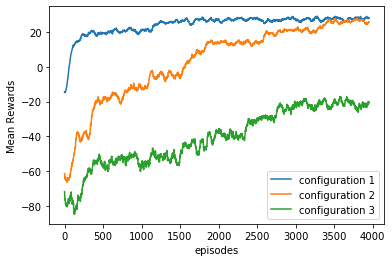

In [56]:
plt.plot(range(EPISODES-50+1), mean_rewards_1, range(EPISODES-50+1), mean_rewards_2, range(EPISODES-50+1), mean_rewards_3)
plt.legend(["configuration 1", "configuration 2", "configuration 3"])
plt.xlabel("episodes")
plt.ylabel("Mean Rewards")
plt.savefig("Question_2_output.png")